In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks")

Mounted at /content/drive


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from numpy.random import seed
seed(1337)
from tensorflow import random
random.set_seed(42)
import tensorflow as tf

from sklearn.metrics import classification_report, accuracy_score
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Dense, Input, Conv1D, MaxPooling1D, Embedding, GlobalMaxPool1D, GlobalMaxPooling1D, SpatialDropout1D, LSTM, Flatten, BatchNormalization, Dropout

In [3]:
data = pd.read_csv('/content/drive/MyDrive/capstone_data/StockTwits_balanced.csv', index_col=0)

In [ ]:
data.head()

,created_at,body,sentiment,Lemmatized_tokens
0,2021-12-21T18:08:24Z,$AMD $NVDA $MU $MRVL $ON Bull Market for the r...,1,"['amd', 'nvda', 'mu', 'mrvl', 'bull', 'market'..."
1,2021-08-23T01:42:37Z,$TSLA I dont care what the price does in short...,1,"['tsla', 'dont', 'care', 'price', 'short', 'te..."
2,2021-04-16T13:32:34Z,$AMZN hmhm lets see where we end.,1,"['amzn', 'hmhm', 'let', 'see', 'end']"
3,2022-01-12T16:11:00Z,$TSLA gap closed ndx its on,1,"['tsla', 'gap', 'closed', 'ndx']"
4,2021-04-05T15:24:51Z,$TSLA okay....who’s the asshole that keeps sel...,1,"['tsla', 'okay', 'asshole', 'keep', 'selling',..."


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['Lemmatized_tokens'], data['sentiment'], test_size=0.2, random_state=42)

In [ ]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (913092,)
X_test: (228274,)
y_train: (913092,)
y_test: (228274,)


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [6]:
vocab_size = len(tokenizer.index_word) + 1
print('Vocab Size:', vocab_size)

Vocab Size: 120321


In [7]:
data_train=pad_sequences(X_train_token)
data_train.shape

(913092, 225)

In [8]:
T=data_train.shape[1]
data_test=pad_sequences(X_test_token, maxlen=T)
data_test.shape

(228274, 225)

In [9]:
# Building the CNN Model
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=T))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(64,3,activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128,3,activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 225, 32)           3850272   
                                                                 
 conv1d (Conv1D)             (None, 223, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 24, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 22, 128)           2

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # default 0.001 learning rate
history2 = model.fit(data_train, y_train, validation_data=(data_test, y_test), epochs=5, batch_size=100)

Epoch 1/5
9131/9131 [==============================] - 133s 14ms/step - loss: 0.5555 - accuracy: 0.6932 - val_loss: 0.5400 - val_accuracy: 0.7057
Epoch 2/5
9131/9131 [==============================] - 77s 8ms/step - loss: 0.5231 - accuracy: 0.7174 - val_loss: 0.5309 - val_accuracy: 0.7111
Epoch 3/5
9131/9131 [==============================] - 76s 8ms/step - loss: 0.5063 - accuracy: 0.7278 - val_loss: 0.5290 - val_accuracy: 0.7148
Epoch 4/5
9131/9131 [==============================] - 74s 8ms/step - loss: 0.4926 - accuracy: 0.7367 - val_loss: 0.5312 - val_accuracy: 0.7145
Epoch 5/5
9131/9131 [==============================] - 81s 9ms/step - loss: 0.4808 - accuracy: 0.7437 - val_loss: 0.5362 - val_accuracy: 0.7122


In [9]:
# CNN + LSTM
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length=T))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 225, 32)           3850272   
                                                                 
 conv1d (Conv1D)             (None, 225, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 112, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 32)           0         
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                        

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # default 0.001 learning rate
history = model.fit(data_train, y_train, validation_data=(data_test, y_test), epochs=5, batch_size=100)

Epoch 1/5
9131/9131 [==============================] - 192s 19ms/step - loss: 0.5327 - accuracy: 0.7232 - val_loss: 0.5079 - val_accuracy: 0.7393
Epoch 2/5
9131/9131 [==============================] - 120s 13ms/step - loss: 0.5057 - accuracy: 0.7406 - val_loss: 0.5059 - val_accuracy: 0.7435
Epoch 3/5
9131/9131 [==============================] - 125s 14ms/step - loss: 0.4930 - accuracy: 0.7486 - val_loss: 0.4970 - val_accuracy: 0.7506
Epoch 4/5
9131/9131 [==============================] - 126s 14ms/step - loss: 0.4842 - accuracy: 0.7541 - val_loss: 0.5033 - val_accuracy: 0.7478
Epoch 5/5
9131/9131 [==============================] - 115s 13ms/step - loss: 0.4778 - accuracy: 0.7585 - val_loss: 0.5012 - val_accuracy: 0.7477


In [13]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(5)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'bo-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'b-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

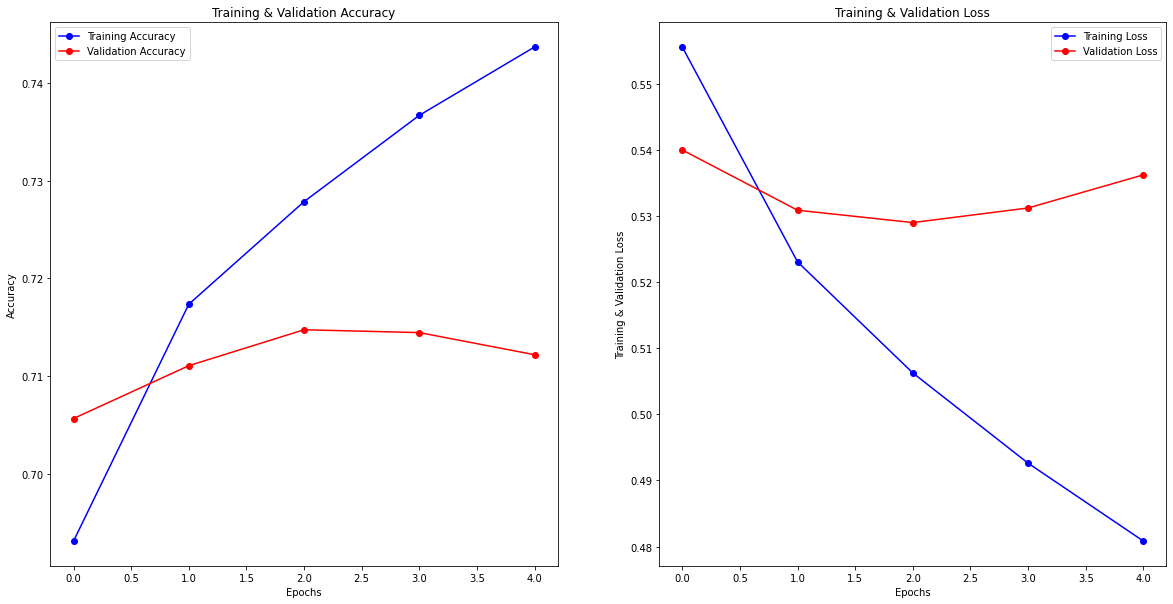

In [14]:
plot_accuracy_loss_chart(history2)

In [15]:
model.save('capstone_CNN.h5')